In [86]:
import os
import pickle
from typing import Union

import numpy as np
import matplotlib.pyplot as plt

In [7]:
project_path = 'C:\\Users\\danny\\Documents_Local\\Caltech_2023-2024\\CS101'

def join_path(relative_path: str) -> str:
    return os.path.join(project_path, relative_path)

def pickle_load(relative_path: str):  # -> pickled_file_contents
    return pickle.load(open(join_path(relative_path), 'rb'))

def pickle_save(obj: object, relative_path: str) -> None:
    pickle.dump(obj, open(join_path(relative_path), 'wb'))

In [8]:
# elev_list = pickle_load('Data\\Collapsed_Data\\elevation_list.pkl')
elev = pickle_load('Data\\Collapsed_Data\\elevation.pkl')

# temp_day_list = pickle_load('Data\\Collapsed_Data\\temp_list.pkl')
temp_day = pickle_load('Data\\Collapsed_Data\\temp.pkl')

# temp_night_list = pickle_load('Data\\Collapsed_Data\\temp_night_list.pkl')
# temp_night = pickle_load('Data\\Collapsed_Data\\temp_night.pkl')

# ref_list = pickle_load('Data\\Collapsed_Data\\reflectance_list.pkl')
ref = pickle_load('Data\\Collapsed_Data\\reflectance.pkl')

good_coords = pickle_load('Data\\Collapsed_Data\\good_coords.pkl')

lat = pickle_load('Data\\Collapsed_Data\\latitude.pkl')
lon = pickle_load('Data\\Collapsed_Data\\longitude.pkl')

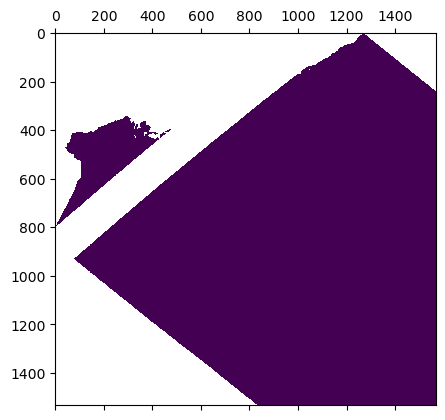

In [41]:
plt.matshow(good_coords[:, :])

(<matplotlib.image.AxesImage at 0x2301e9be410>, (1000, 800), 0)

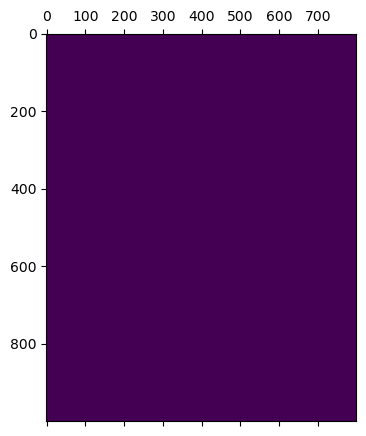

In [104]:
i1, i2, j1, j2 = 400, 1400, 768, None
test = good_coords[i1:i2, j1:j2]
plt.matshow(test), test.shape, np.isnan(test).sum()

In [90]:
def cnn_filter(
    a: np.ndarray,
    iinds: Union[np.ndarray[bool], list[bool]],
    jinds: Union[np.ndarray[bool], list[bool], None] = None,
) -> np.ndarray:
    '''
    Returns a filtered version of an array according to provided indices

    Input:
        a: the numpy array to be filtered
        iinds: list or 1-D numpy array of booleans telling which rows to keep
        jinds: list or 1-D numpy array of booleans telling which columns to keep
    
    Returns:
        Filtered numpy array
    '''
    if len(a.shape) == 1:
        a = a[:, np.newaxis, np.newaxis]
    if len(a.shape) == 2:
        a = a[:, :, np.newaxis]
    a = a[iinds, :, :]
    if jinds is not None:
        a = a[:, jinds, :]
    return a.squeeze()

In [106]:
cnn_iind = np.concatenate(
    [
        np.zeros(400, dtype=bool),
        np.ones(1000, dtype=bool),
        np.zeros(good_coords.shape[0] - 1400, dtype=bool),
    ]
)
cnn_jind = np.concatenate(
    [
        np.zeros(768, dtype=bool),
        np.ones(good_coords.shape[1] - 768, dtype=bool)
    ]
)

In [107]:
elev_cnn = cnn_filter(elev, cnn_iind, cnn_jind)
ref_cnn = cnn_filter(ref, cnn_iind, cnn_jind)
temp_cnn = cnn_filter(temp_day, cnn_iind, cnn_jind)
gc_cnn = cnn_filter(good_coords, cnn_iind, cnn_jind)
lat_cnn = cnn_filter(lat, cnn_iind)
lon_cnn = cnn_filter(lon, cnn_jind)

In [108]:
pickle_save(elev_cnn, 'Data\\CNN_Data\\elevation_cnn.pkl')
pickle_save(ref_cnn, 'Data\\CNN_Data\\reflectance_cnn.pkl')
pickle_save(temp_cnn, 'Data\\CNN_Data\\temp_cnn.pkl')
pickle_save(gc_cnn, 'Data\\CNN_Data\\good_coords_cnn.pkl')
pickle_save(lat_cnn, 'Data\\CNN_Data\\latitude_cnn.pkl')
pickle_save(lon_cnn, 'Data\\CNN_Data\\longitude_cnn.pkl')

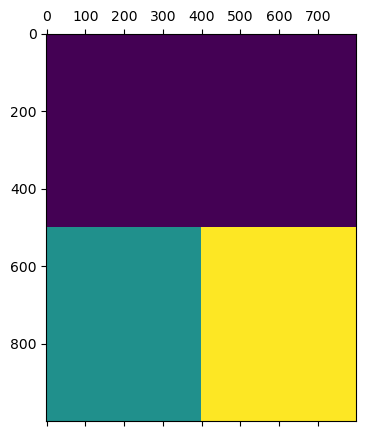

In [150]:
splits = np.zeros_like(gc_cnn)
splits[500:, :400] += 1
splits[500:, 400:] += 2
plt.matshow(splits)

In [152]:
pickle_save(
    elev_cnn[:500, :], 'Data\\CNN_Data\\Splits\\elevation_cnn_train.pkl'
)
pickle_save(
    ref_cnn[:500, :], 'Data\\CNN_Data\\Splits\\reflectance_cnn_train.pkl'
)
pickle_save(
    temp_cnn[:500, :], 'Data\\CNN_Data\\Splits\\temp_cnn_train.pkl'
)
pickle_save(
    elev_cnn[500:, :400], 'Data\\CNN_Data\\Splits\\elevation_cnn_val.pkl'
)
pickle_save(
    ref_cnn[500:, :400], 'Data\\CNN_Data\\Splits\\reflectance_cnn_val.pkl'
)
pickle_save(
    temp_cnn[500:, :400], 'Data\\CNN_Data\\Splits\\temp_cnn_val.pkl'
)
pickle_save(
    elev_cnn[500:, 400:], 'Data\\CNN_Data\\Splits\\elevation_cnn_test.pkl'
)
pickle_save(
    ref_cnn[500:, 400:], 'Data\\CNN_Data\\Splits\\reflectance_cnn_test.pkl'
)
pickle_save(
    temp_cnn[500:, 400:], 'Data\\CNN_Data\\Splits\\temp_cnn_test.pkl'
)

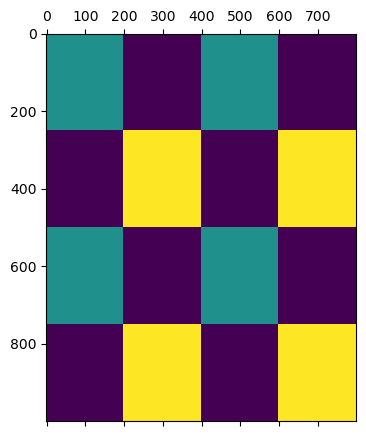

In [147]:
splits = np.zeros_like(gc_cnn)
splits[:250, :200] += 1
splits[:250, 400:600] += 1
splits[250:500, 200:400] += 2
splits[250:500, 600:] += 2
splits[500:750, :200] += 1
splits[500:750, 400:600] += 1
splits[750:, 200:400] += 2
splits[750:, 600:] += 2
plt.matshow(splits)

In [149]:
# pickle_save(splits, 'Data\\CNN_Data\\alternate_splits.pkl')

# Test the dataset class CNNDataset in Datasets.py

In [158]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [163]:
import sys
import importlib
sys.path.append(join_path('EMIT-ECOSTRESS\\modules'))
import data.Datasets
import models.TestCNN
import utils.train

In [239]:
# Make datasets and dataloaders

# setup

importlib.reload(data.Datasets)

omit_components = 244 - 244

batch_size = 1

base_data_path = 'Data\\CNN_Data\\Splits'

device = ['cuda' if torch.cuda.is_available() else 'cpu' for i in [0]][0]


# load data

emit_train = pickle_load(
    os.path.join(base_data_path, 'reflectance_cnn_train.pkl')
)
emit_val = pickle_load(os.path.join(base_data_path, 'reflectance_cnn_val.pkl'))

elev_train = pickle_load(
    os.path.join(base_data_path, 'elevation_cnn_train.pkl')
)
elev_val = pickle_load(os.path.join(base_data_path, 'elevation_cnn_val.pkl'))

eco_train = pickle_load(os.path.join(base_data_path, 'temp_cnn_train.pkl'))
eco_val = pickle_load(os.path.join(base_data_path, 'temp_cnn_val.pkl'))


# create datasets and dataloaders

train_dataset = data.Datasets.CNNDataset(
    emit_data=emit_train,
    omit_components=omit_components,
    ecostress_data=eco_train,
    ecostress_center=None,
    ecostress_scale=None,
    additional_data=(elev_train,),
    y_size=100,
    x_size=100,
)

val_dataset = data.Datasets.CNNDataset(
    emit_data=emit_val,
    omit_components=omit_components,
    ecostress_data=eco_val,
    ecostress_center=None,
    ecostress_scale=None,
    additional_data=(elev_val,),
    y_size=100,
    x_size=100,
)

train_loader = DataLoader(
    dataset=train_dataset, batch_size=None#, drop_last=True
)
val_loader = DataLoader(
    dataset=val_dataset, batch_size=None#, drop_last=True
)

In [240]:
# Make model, optimizer, and loss function
importlib.reload(models.TestCNN)

n_epochs = 3

model = models.TestCNN.TestCNN(y_size=100, x_size=100, input_dim=245)

if device == 'cuda':
    model = model.cuda()

optimizer = optim.Adam(
    params=model.parameters(), lr=0.0001, weight_decay=0, fused=True
)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer, factor=0.5, patience=2
)
# scheduler = None

loss_fn = nn.MSELoss(reduction='sum')

model

TestCNN(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)

In [241]:
importlib.reload(utils.train)
train_loss, val_loss = utils.train.train(
    model,
    optimizer,
    scheduler,
    loss_fn,
    train_loader,
    val_loader,
    n_epochs=n_epochs,
    loss_interval=1,
    device=device,
)

Epoch 000	 Train Loss: 1.8406e+04	 Val Loss: 1.8207e+04 	 Avg Error: 678.44	LR: 0.0001	Time: 0.75
Epoch 001	 Train Loss: 1.8377e+04	 Val Loss: 1.8141e+04 	 Avg Error: 677.22	LR: 0.0001	Time: 0.67
Epoch 002	 Train Loss: 1.8313e+04	 Val Loss: 1.8079e+04 	 Avg Error: 676.06	LR: 0.0001	Time: 0.65
Epoch 003	 Train Loss: 1.825e+04	 Val Loss: 1.8018e+04 	 Avg Error: 674.91	LR: 0.0001	Time: 0.65
